# Cab-Driver Agent

### Deep Q-Learning based RL model for assisting cab drivers to maximise the Profits over a period of 30 days working across 5 cities. 

Developed by -

Abhishek Singh (aulakh.abhishek@gmail.com) <br>

#### Hyperparameters defined in Environment (MDP state) 
1. m = 5 # number of cities, ranges from 1 ..... m <br>
2.  t = 24 # number of hours, ranges from 0 .... t-1 <br>
3.  d = 7  # number of days, ranges from 0 ... d-1 <br>
4.  C = 5 # Per hour fuel and other costs <br>
5.  R = 9 # per hour revenue from a passenger <br>

### 1. Importing the Libraries 

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

### 2. Load the Environment (MDP State) as Env.py

In [2]:
# Import the environment
from Env import CabDriver
env = CabDriver()

- Verify the size of Environment State Space, initialised State, possible Action Space 

In [3]:
print('State Space Size: ', len(env.state_space))
print('State Init: ', env.state_init)
print('Action Space: ',env.action_space)

State Space Size:  840
State Init:  (4, 0, 0)
Action Space:  [(1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (0, 0)]


- The Environment (Env.py) allows us to execute a test run, Let's try to check the results 

In [4]:
%%time
env.test_run()

Current State: (4, 0, 0)
Request: ([15, 6, 14, 5, 20, 9, 19, 17, 4, 18], [(4, 5), (2, 4), (4, 4), (2, 3), (0, 0), (3, 2), (5, 4), (5, 2), (2, 1), (5, 3)])
Rewards: [8, 20, 0, 20, -5, 20, 8, 16, 8, 4]
New Possible States: [(5, 2, 0), (4, 10, 0), (4, 0, 0), (3, 10, 0), (4, 1, 0), (2, 16, 0), (4, 4, 0), (2, 6, 0), (1, 7, 0), (3, 3, 0)]
Maximum Reward : 20
Action : (2, 4)
Total Travel Hours : 59
New State : (4, 10, 0)
NN Input Layer (Arch#1) : [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
NN Input Layer (Arch#2) : [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Wall time: 1.99 ms


### 3. Defining Time Matrix

In [5]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy") #data_path + 

### 4. Tracking the state-action pairs for checking convergence


- Defining functions to enocde the tracked states, actions

In [6]:
def encode_track_state(state):
  return('-'.join(str(s) for s in state))

In [7]:
def encode_track_action(action):
  return('-'.join(str(a) for a in action))

- Function to initilise tracking states & q-values

In [8]:
def initialise_tracking_states(episodes):
  sample_q_value = [('4-0-0', '1-2'), ('4-0-0', '2-1'), ('4-0-0', '1-3'), ('4-0-0', '3-1'), ('4-0-0', '1-4'), ('4-0-0', '4-1'), ('4-0-0', '1-5'),
                    ('4-0-0', '5-1'), ('4-0-0', '2-3'), ('4-0-0', '3-2'), ('4-0-0', '2-4'), ('4-0-0', '4-2'), ('4-0-0', '2-5'), ('4-0-0', '5-2'), 
                    ('4-0-0', '3-4'), ('4-0-0', '4-3'), ('4-0-0', '3-5'), ('4-0-0', '5-3'), ('4-0-0', '4-5'), ('4-0-0', '5-4'), ('4-0-0', '0-0')]
  for q_value in sample_q_value:
    state = q_value[0]
    action = q_value[1]
    States_track[state][action] = []


- Function to save the State-Action Pair Values

In [9]:
def save_tracking_states(curr_state, curr_action, curr_q_value):
  for state in States_track.keys():
    if state == curr_state:
      for action in States_track[state].keys():
        if action == curr_action:
          States_track[state][action].append(curr_q_value)

- Funciton to save the model object into a pickle file

In [10]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### 5. Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

##### DQNAgent Class 
- Use of Epsilon greedy & decay strategy to make use of Exploration vs Exploitation
- Building the DQN model architecture
- Populate replay buffer memory 
- Training of main DQN network & and 
- Updating the target model weight after episodes
- Save model weights

In [11]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate =  0.001        
        self.epsilon = 1.0
        self.epsilon_decay =  .999
        self.epsilon_min = 0.01
        
        self.batch_size = 32
        self.train_start = 50        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        #print("\n Main Neural Network Model: ",self.model.summary())
        self.target_model = self.build_model()
        #print("\n Target Neural Network Model: ",self.target_model.summary())
        print("\n Main & Target Model Built")

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        # Layer 2 
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # Layer 3
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # Layer 4
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # Layer 5
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        # Compile the model
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        #model.summary
        return model

    def update_target_model(self):
      # Update the target Q-value n/w from main Q-value n/w after training of episode
      self.target_model.set_weights(self.model.get_weights())


    def get_action(self, state, possible_actions):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
      if np.random.rand() <= self.epsilon:
        choice = random.choice(possible_actions)

      else:
        q_values = self.model.predict(state)
        possible_action_q_values = list(q_values[0][index] for index in possible_actions)
        max_q_value = np.max(possible_action_q_values)
        choice = np.where(q_values[0] == max_q_value)
        choice = choice[0][0]
      
      return choice

    def get_q_values(self, state):
      return self.model.predict(state)[0]


    #
    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
      # append the tuple (s, a , r , s' done) to the Replay buffer memory after every action
      self.memory.append((state, action, reward, next_state, done))

      # decay the ε after each sample from the environment
      if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        # Training will start only when the Memory size is greater than Batch Size
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                #state, actions, rewards, next_state = mini_batch[i]
                update_input[i] = mini_batch[i][0]
                actions.append(mini_batch[i][1])
                rewards.append(mini_batch[i][2])
                update_output[i] = mini_batch[i][3]
                terminal_states.append(mini_batch[i][4])                
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_q_value = self.target_model.predict(update_output)
            
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
              if terminal_states[i]:
                target[i][actions[i]] =  rewards[i]
              else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_q_value[i])
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def save_model_weight(self, name):
      self.model.save_weights(name)

    def get_model_weights(self):
      return self.model.get_weights()

    def save(self, name):
        self.model.save(name)

- Number of Episodes to run is set to 2000

In [12]:
Episodes = 2000

### 6. DQN initialization block

- Initialisation of state, encoding, state-size, action-size and tracking-states

In [128]:
import pylab
scores, episodes = [], []

# Initialise the state & action
state = env.state_init
state_encoded = env.state_encod_arch1(state)
state_size = len(state_encoded)
action_size = len(env.action_space)

# Instantiate the DQNAgent class for Architecture#1
agent = DQNAgent(state_size,action_size)

# Tracking states
States_track =  collections.defaultdict(dict)
initialise_tracking_states(Episodes)


 Main & Target Model Built


### 7. DQN Model Training 

Episodes: 50 Score: 1828 Memory Length: 2000 Epsilon: 0.009998671593271896
----------------------------------------------------------------------------------------------
Episodes: 100 Score: 1936 Memory Length: 2000 Epsilon: 0.009998671593271896
----------------------------------------------------------------------------------------------
Episodes: 150 Score: 1663 Memory Length: 2000 Epsilon: 0.009998671593271896
----------------------------------------------------------------------------------------------
Episodes: 200 Score: 2088 Memory Length: 2000 Epsilon: 0.009998671593271896
----------------------------------------------------------------------------------------------
Episodes: 250 Score: 1928 Memory Length: 2000 Epsilon: 0.009998671593271896
----------------------------------------------------------------------------------------------
Episodes: 300 Score: 1787 Memory Length: 2000 Epsilon: 0.009998671593271896
----------------------------------------------------------------------

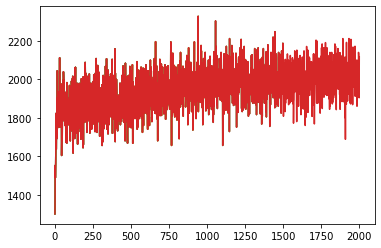

In [14]:
%%time
for episode in range(Episodes):
    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    terminal_state = False
    score = 0
    reward = 0
    total_days = 1
    previous_day = 0
    current_day = 0

    env.reset()
   
    #Call the DQN agent
    action_space, state_space, state = env.reset()
    track_state = state
    
    
    while not terminal_state:

        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss

        state_encoded = env.state_encod_arch1(state)
        state_encoded = np.reshape(state_encoded, [1, state_size])

        # Get possible list of actions from the Env
        possible_actions, action_list = env.requests(state)

        # Epsilon Greedy policy
        action = agent.get_action(state_encoded, possible_actions)

        # next reward and next state
        reward = env.reward_func(state, env.action_space[action], Time_matrix)
        next_state = env.next_state_func(state, env.action_space[action], Time_matrix)
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])

        # Append the experiences to Replay Buffer memory
        agent.append_sample(state_encoded, action, reward, next_state_encoded, terminal_state)

        # Model training
        agent.train_model()


        # Reward tracking
        score += reward
        previous_day = state[2]
        state = next_state
        current_day = state[2]

        if previous_day != current_day:
          total_days += 1

        if total_days > 30:
          terminal_state = True

        # After 30 days, Target model is updated while scores and episodes are saved off
        if terminal_state:
          agent.update_target_model()
          scores.append(score)
          episodes.append(episode)
        
    
    # Q-value convergence | After episode, all predicted Q-values from possible actions stored
    track_state_encode = encode_track_state(track_state)
    track_state_encoded = env.state_encod_arch1(track_state)
    track_state_encoded = np.reshape(track_state_encoded, [1, state_size])
    track_q_values = agent.get_q_values(track_state_encoded)

    for index in range(len(env.action_space)):
      track_action_encode = encode_track_action(env.action_space[index])
      save_tracking_states(track_state_encode, track_action_encode, track_q_values[index])
        
    #print('Episode counter = ',episode )

    # Save the graph, model and pickle file 
    if ( episode + 1 ) % 50 == 0:  #200 == 0:
      print('Episodes: {} Score: {} Memory Length: {} Epsilon: {}'.format(episode + 1,score,len(agent.memory), agent.epsilon))
      print('----------------------------------------------------------------------------------------------')
    if ( episode + 1 ) % 500 == 0:
        pylab.plot(episodes, scores)
        pylab.savefig('CabDriverDQN' + str(score) + '.png')
        agent.save('CabDriverDQN' + str(score) + '.h5')
        # Pickle file
        save_obj(agent.get_model_weights(), 'CabDriverDQN' + str(score))
#End

- The model training finished with a total score per episode converging to value of around 2000

### 8. Tracking Convergence

- Plot for Accumlated rewards(Score) vs Episode

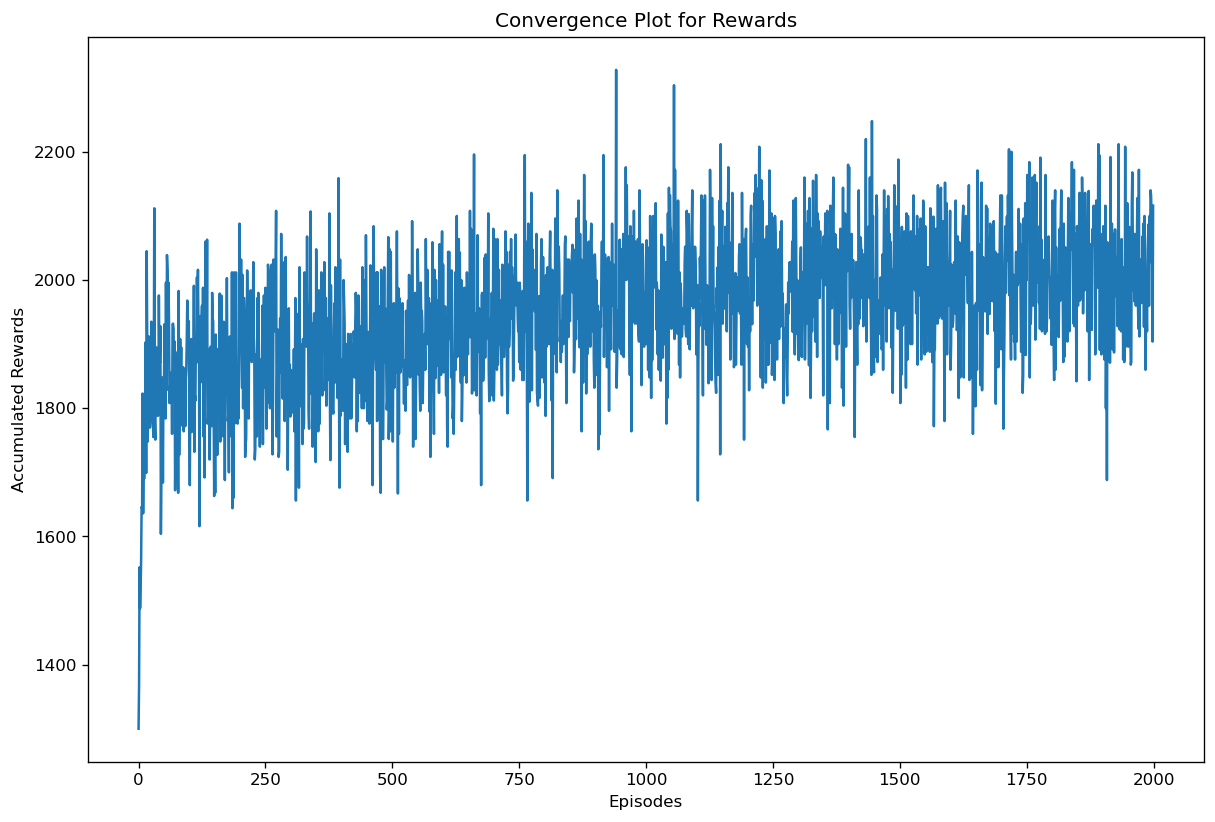

In [15]:
# convergence with scores
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':120})
plt.plot(episodes, scores)
plt.xlabel('Episodes')
plt.ylabel('Accumulated Rewards')
#plt.legend()
plt.title('Convergence Plot for Rewards')
plt.show()

- Plot for Q-Value(State-Action Pair) for couple of state and actions 

In [18]:
States_track

defaultdict(dict,
            {'4-0-0': {'1-2': [0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
      

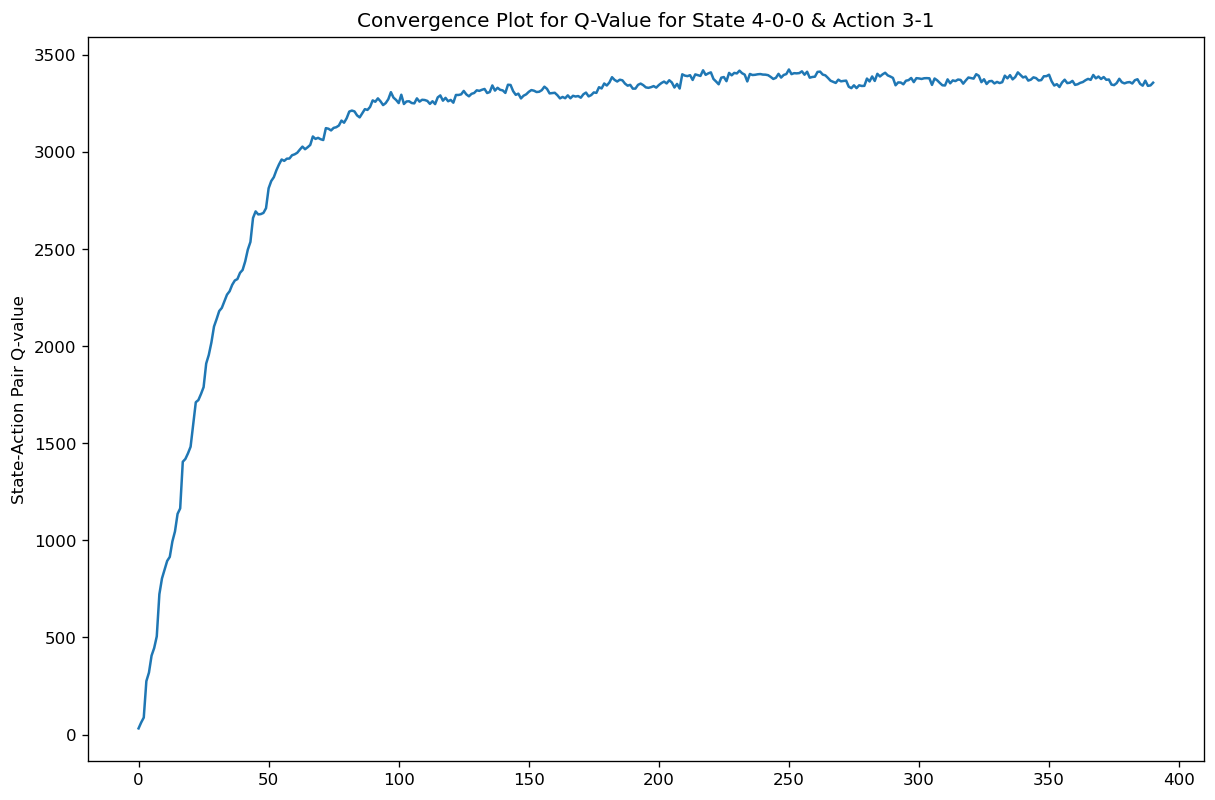

In [24]:
# State-action q-value graph
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':120})
values = States_track['4-0-0']['3-1']
plt.plot(values)
plt.ylabel('State-Action Pair Q-value')
#plt.legend()
plt.title('Convergence Plot for Q-Value for State 4-0-0 & Action 3-1')
plt.show()


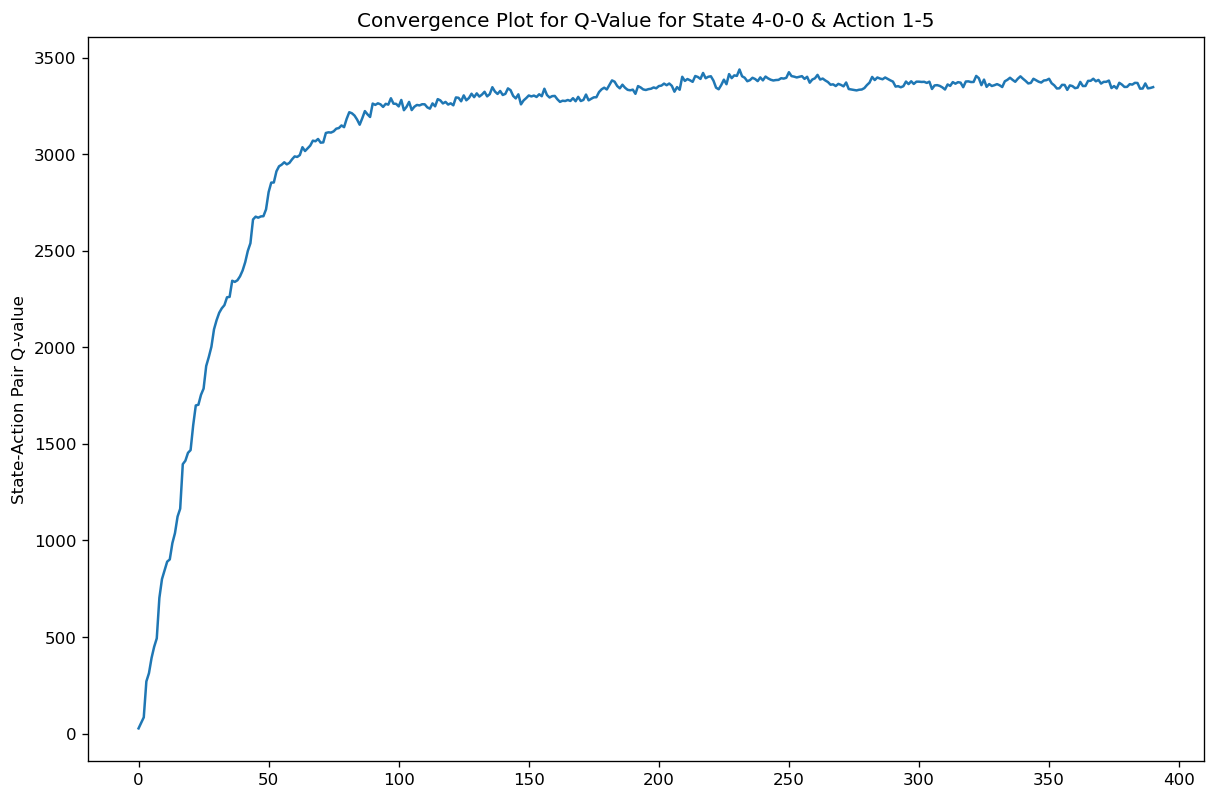

In [25]:
# State-action q-value graph
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':120})
values = States_track['4-0-0']['1-5']
plt.plot(values)
plt.ylabel('State-Action Pair Q-value')
plt.title('Convergence Plot for Q-Value for State 4-0-0 & Action 1-5')
plt.show()


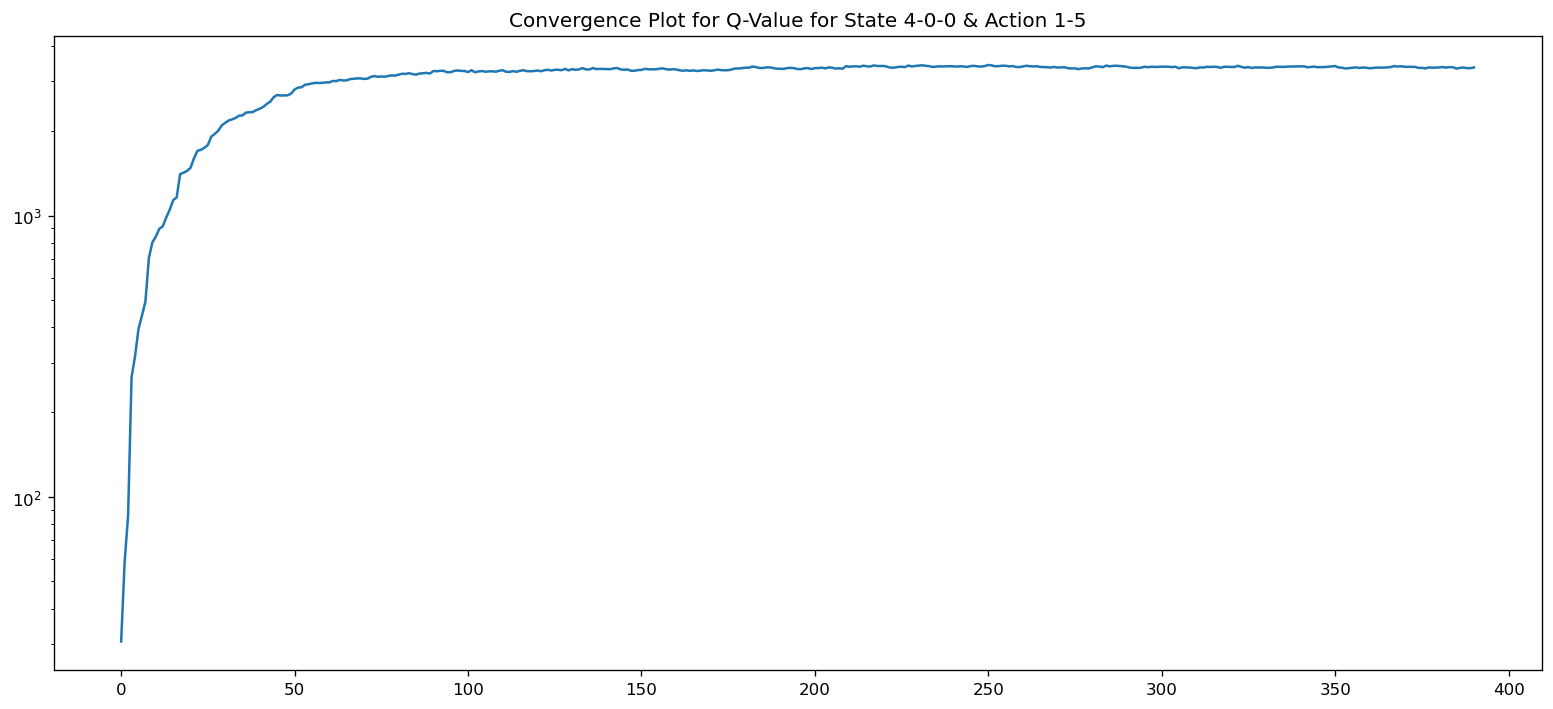

In [127]:
plt.figure(0, figsize=(16,7))
plt.title('Convergence Plot for Q-Value for State 4-0-0 & Action 2-5')
values_sem = States_track['4-0-0']['2-5']
#xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(values_sem)
plt.show()

#### Epsilon-decay sample function

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

### Epsilon decay Plot 

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

- First method 

In [14]:
timesteps = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.001*i))

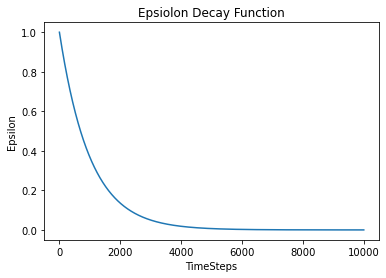

In [15]:
plt.plot(timesteps, epsilon)
plt.ylabel('Epsilon')
plt.xlabel('TimeSteps')
plt.title('Epsiolon Decay Function')
plt.show()

- Second method (used in the DQNAgent class) 

In [16]:
timesteps = 10000
epsilon = 1.0
epsilon_decay = 0.999
epsilon_min = 0.01
epsilon_list_decay = []

In [17]:
for i in range(timesteps):
    if (epsilon > epsilon_min):
        epsilon *=epsilon_decay
        epsilon_list_decay.append(epsilon)
        print(epsilon)
    else:
        epsilon_list_decay.append(epsilon)

0.999
0.998001
0.997002999
0.996005996001
0.995009990004999
0.994014980014994
0.993020965034979
0.9920279440699441
0.9910359161258742
0.9900448802097482
0.9890548353295385
0.988065780494209
0.9870777147137147
0.986090636999001
0.9851045463620021
0.98411944181564
0.9831353223738244
0.9821521870514506
0.9811700348643991
0.9801888648295347
0.9792086759647052
0.9782294672887405
0.9772512378214517
0.9762739865836303
0.9752977125970467
0.9743224148844496
0.9733480924695651
0.9723747443770956
0.9714023696327185
0.9704309672630859
0.9694605362958227
0.9684910757595269
0.9675225846837673
0.9665550620990835
0.9655885070369844
0.9646229185299474
0.9636582956114175
0.9626946373158061
0.9617319426784903
0.9607702107358118
0.959809440525076
0.9588496310845509
0.9578907814534664
0.9569328906720129
0.9559759577813409
0.9550199818235596
0.9540649618417361
0.9531108968798944
0.9521577859830145
0.9512056281970315
0.9502544225688344
0.9493041681462656
0.9483548639781193
0.9474065091141411
0.94645910260502

0.06545689732805193
0.06539144043072388
0.06532604899029316
0.06526072294130288
0.06519546221836157
0.06513026675614321
0.06506513648938707
0.06500007135289768
0.06493507128154478
0.06487013621026325
0.06480526607405299
0.06474046080797893
0.06467572034717095
0.06461104462682378
0.06454643358219696
0.06448188714861476
0.06441740526146615
0.06435298785620469
0.06428863486834849
0.06422434623348014
0.06416012188724667
0.06409596176535942
0.06403186580359406
0.06396783393779047
0.06390386610385268
0.06383996223774882
0.06377612227551108
0.06371234615323557
0.06364863380708233
0.06358498517327525
0.06352140018810197
0.06345787878791387
0.06339442090912595
0.06333102648821683
0.06326769546172861
0.06320442776626688
0.06314122333850061
0.06307808211516211
0.06301500403304695
0.0629519890290139
0.06288903703998489
0.0628261480029449
0.06276332185494196
0.06270055853308702
0.06263785797455393
0.06257522011657937
0.0625126448964628
0.062450132251566336
0.062387682119314766
0.06232529443719545
0

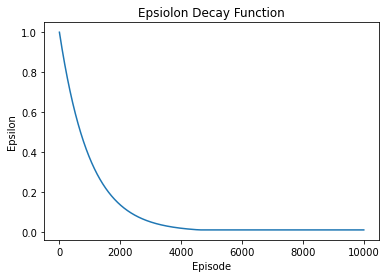

In [18]:
time = np.arange(0,10000)
plt.plot(time, epsilon_list_decay)
plt.ylabel('Epsilon')
plt.xlabel('Episode')
plt.title('Epsiolon Decay Function')
plt.show()

### Alternate method to build decay function for applying Exploration vs Exploitation 

In [59]:
ALPHA=0.5
BETA=0.1
DECAY_RATE=0.999
TIMESTEPS = 2000
def Epsilon(time):
    standardized_time=(time-ALPHA*TIMESTEPS)/(BETA*TIMESTEPS)
    cosh=np.cosh(math.exp(-standardized_time))
    eps=1.1-(1/cosh+(time*DECAY_RATE/TIMESTEPS))
    return eps

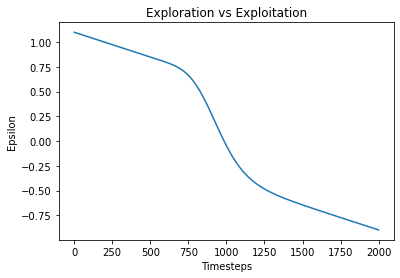

In [60]:
new_time=list(range(0,TIMESTEPS))
y=[Epsilon(time) for time in new_time]
plt.plot(new_time,y)
plt.ylabel('Epsilon')
plt.xlabel('Timesteps')
plt.title('Exploration vs Exploitation')
plt.show()

---
Thanks & Regards <br>
Abhishek Singh (aulakh.abhishek@gmail.com) <br>
Dated - 16 Feb 2022